<a href="https://colab.research.google.com/github/worawit-saetan/The-Boston-Housing-Price-dataset---Predicting-house-prices-with-DNN/blob/main/The_Boston_Housing_Price_dataset_Predicting_house_prices_with_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Boston Housing Price dataset - Predicting house prices with DNN
We ’ll build a deep neural network model to predict house prices (scalar regression problem)

## The outline is as follows

*   load the boston_housing dataset from Keras 
*   do feature normalization
*   build the deep neural network model
*   validate the model using K-fold validation (small validation set)
*   find the proper number of epochs (hyperparameter tuning)
*   plot the validation metrics (MAE)
*   retrain the model with all training data (including validation data) 
*   evaluate the model with test data









In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [4]:
print(train_data.shape) 
print(train_targets.shape)
print(test_data.shape)
print(test_targets.shape)

(404, 13)
(404,)
(102, 13)
(102,)


In [10]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

The targets are the median values of owner-occupied homes in thousands of dollars, for example 15.2k $

In [11]:
train_targets[0]

15.2

Preparing the data : do feature-wise normalization

In [20]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

creat function that build the DNN model

the metric is mean absolute error(MAE)

the loss function is mse

In [21]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

Validating the model using K-fold validation, due to the small size of validation set (we have small dataset)

In [23]:
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [24]:
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate(
  [train_data[:i * num_val_samples],
  train_data[(i + 1) * num_val_samples:]],
  axis=0)
  partial_train_targets = np.concatenate(
  [train_targets[:i * num_val_samples],
  train_targets[(i + 1) * num_val_samples:]],
  axis=0)
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
  epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


validation scores vary from 1.9 to 2.8

The average (2.54) is a much more reliable metric than any single score—that’s the entire point of K-fold cross-validation.

In [25]:
all_scores

[1.9332455396652222, 2.7210943698883057, 2.7185370922088623, 2.824211835861206]

In [26]:
np.mean(all_scores)

2.549272209405899

Let’s try training the network a bit longer: 500 epochs. To keep a record of how well the model does at each epoch, we will modify the training loop to save the per-epoch validation score log.

In [28]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print('processing fold #', i)

  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

  partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
  partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)

  model = build_model()

  history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


then compute the average of the per-epoch MAE scores for all folds.

In [29]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Plotting validation scores

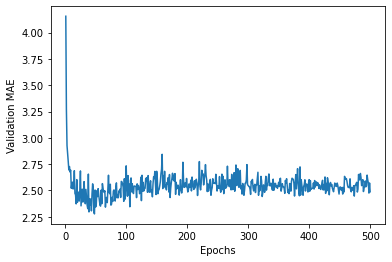

In [30]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance. Let’s do the following

+ Omit the first 10 data points, which are on a different scale than the rest of the curve.
+ Replace each point with an exponential moving average of the previous points,
to obtain a smooth curve.

In [35]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points


Plotting validation scores, excluding the first 10 data points

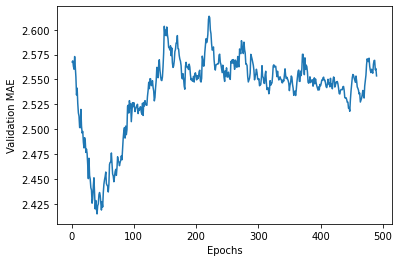

In [36]:
  smooth_mae_history = smooth_curve(average_mae_history[10:])
  
  plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
  plt.xlabel('Epochs')
  plt.ylabel('Validation MAE')
  plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs. Past that point, you start overfitting.

Training the final model

In [37]:
model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 15.9362 - mae: 2.5306


In [38]:
test_mae_score

2.53062105178833

You’re still off by about $2,530.